In [ ]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from sklearn.metrics import confusion_matrix
from transformers import TextClassificationPipeline

plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
PATH = "/content/drive/MyDrive/movie.csv"

df = pd.read_csv(PATH)
print("Shape : \n", "-"*10,"\n", df.shape)
print("\nNull Values : \n", "-"*10,"\n", df.isnull().sum())

Shape : 
 ---------- 
 (40000, 2)

Null Values : 
 ---------- 
 text     0
label    0
dtype: int64


In [ ]:
df.head(5)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
id2label = {
    0 : 'Negative',
    1 : 'Positive'
}

label2id = {v : k for k, v in id2label.items()}
num_classes = len(label2id)
print(label2id)

{'Negative': 0, 'Positive': 1}


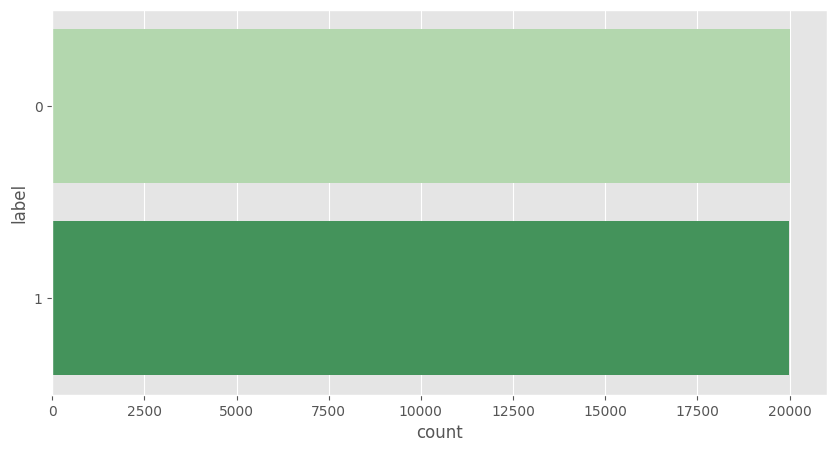

In [ ]:
plt.subplots(figsize = (10, 5))
sns.countplot(y = df['label'], palette='Greens')
plt.show()

  0%|          | 0/40000 [00:00<?, ?it/s]

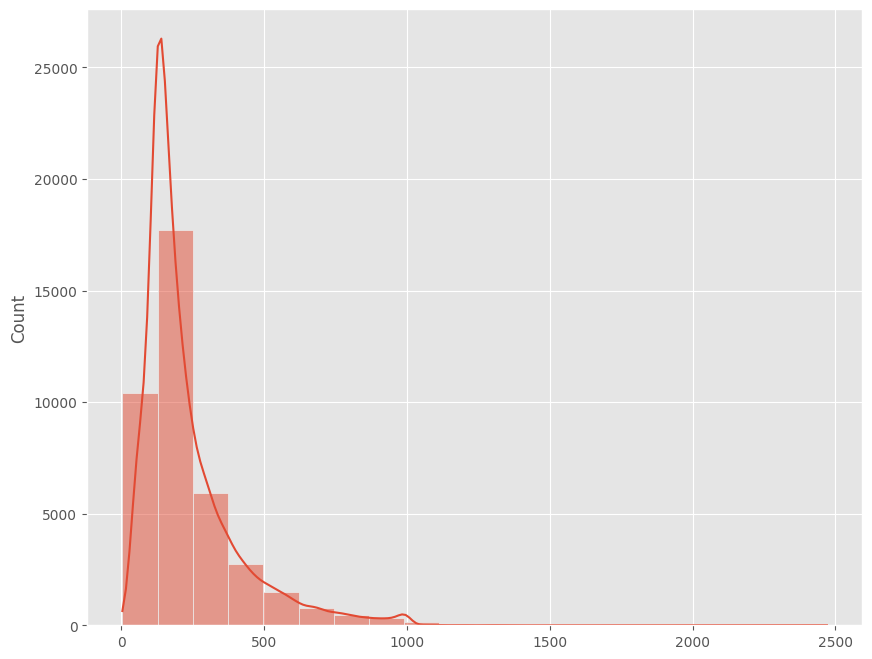

In [ ]:
length = []
for txt in tqdm(df['text'].values):
  length.append(len(txt.split(" ")))

plt.subplots(figsize = (10,8))
sns.histplot(length, bins = 20, kde=True)
plt.show()

In [ ]:
X, y = df['text'].values, df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((36000,), (4000,), (36000,), (4000,))

In [ ]:
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
train_encodings = tokenizer(list(X_train), padding = "max_length", truncation=True)
val_encodings = tokenizer(list(X_val), padding = "max_length", truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(BATCH_SIZE)


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(BATCH_SIZE)

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels = num_classes,
    label2id = label2id,
    id2label = id2label
)

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),
    metrics = ["accuracy"]
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 3

history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = EPOCHS
)

Epoch 1/3
4500/4500 [==============================] - 4483s 984ms/step - loss: 0.2510 - accuracy: 0.8977 - val_loss: 0.1944 - val_accuracy: 0.9270
Epoch 2/3
4500/4500 [==============================] - 4471s 994ms/step - loss: 0.1405 - accuracy: 0.9496 - val_loss: 0.1903 - val_accuracy: 0.9255
Epoch 3/3
4500/4500 [==============================] - 4435s 986ms/step - loss: 0.0931 - accuracy: 0.9685 - val_loss: 0.2159 - val_accuracy: 0.9190


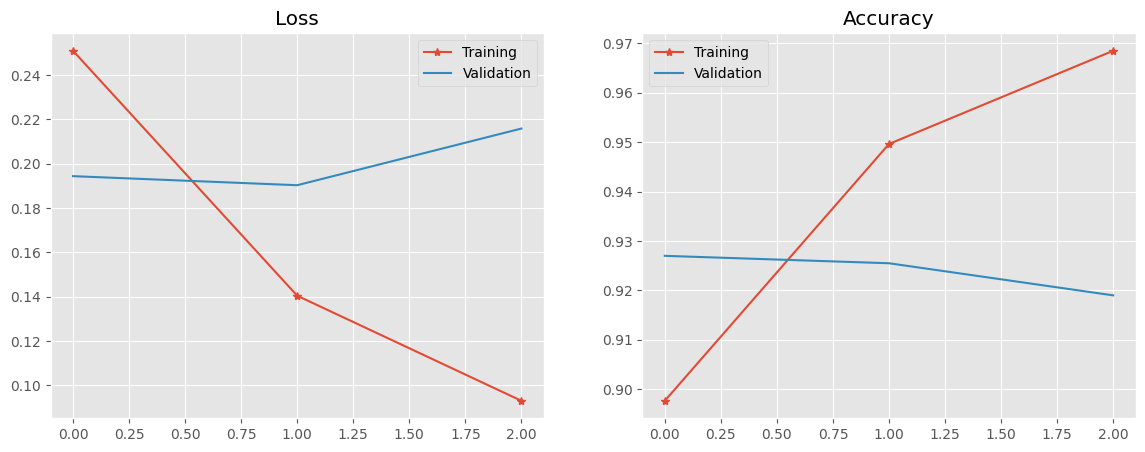

In [ ]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = '*', label = 'Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = '*', label = 'Training')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()

In [ ]:
out = model.predict(val_dataset)
pred = np.argmax(out[0], axis = 1)
pred

500/500 [==============================] - 169s 338ms/step


array([1, 1, 0, ..., 0, 0, 0])

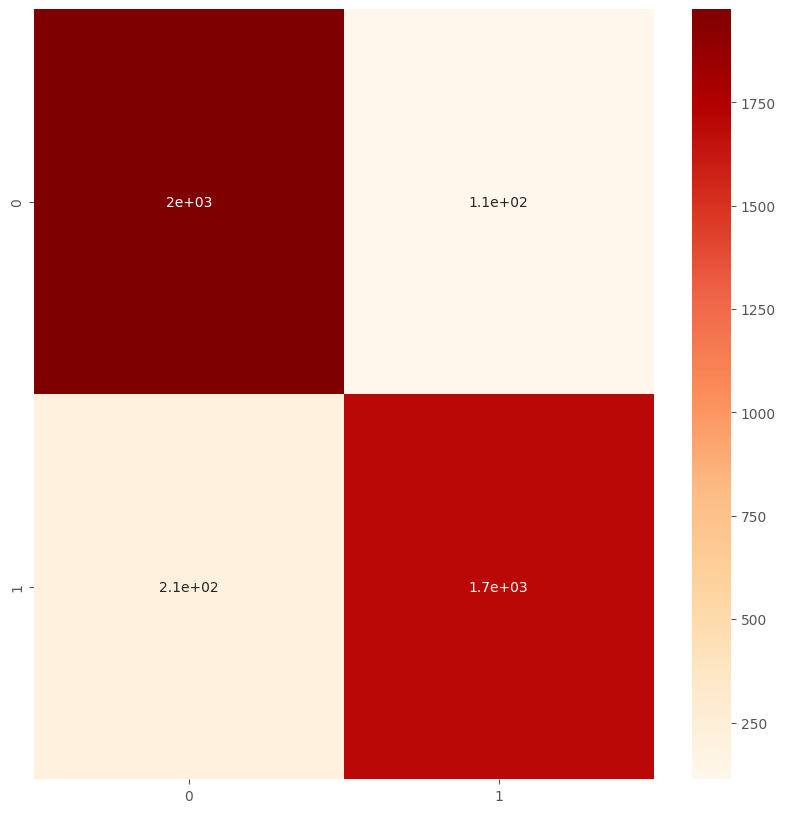

In [ ]:
cm = confusion_matrix(y_val, pred)
plt.subplots(figsize = (10, 10))
sns.heatmap(cm, annot = True, cmap="OrRd")
plt.show()

In [ ]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k = num_classes)
text = "FINALLY!!! A video game adaptation worthy of seeing! It just goes to show what can happen when you follow the source material, bring on the same people responsible for the success of the game, pour your heart into it, and have the original creator take the helm. Halo (Paramount+) could learn some very valuable lessons from The Last of Us (HBO). Do not walk, RUN to see this show!"
pred = pipe(text)

print(pred[0])

[{'label': 'Positive', 'score': 0.9963881969451904}, {'label': 'Negative', 'score': 0.0036117706913501024}]
